>> # INTRO

 # Breast Cancer Detection using deep learning


 - Breast cancer is the second leading cause of cancer deaths among U.S. women, it is a type of cancer that starts when cells begin to grow out of control
 - Most breast cancers begin in the ducts that  carry milk to the nipple (ductal cancers), 
 - Breast cancer can spread when the cancer cells get into the blood or lymph system and are carried to other parts of the body. 
 - Cancerous breast tumors are detected by a special type of examination, which is screening mammogram

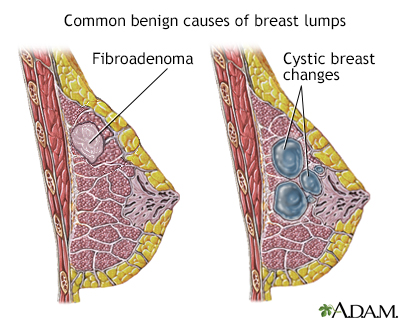

Detection of breast cancer on screening mammography is challenging as an image classification task because the tumors themselves occupy only a small portion of the image of the entire breast. For example, a full-field digital mammography (FFDM) image is typically 4000 × 3000 pixels while a potentially cancerous region of interest (ROI) can be as small as 100 × 100 pixels.



 This explains the large number that we have in the data, which is more than **a quarter of a million** images!

**Our goal:** Given a patient and a patch of a tissue slice predict wheather it contains IDC or not.

>> # CODE

> # Import  Libraries 

In [ ]:
import os
import numpy as np
import shutil
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import itertools


from skimage.filters import gaussian
from skimage.util import random_noise
import matplotlib.image as mpimg

from sklearn.model_selection import train_test_split



import tensorflow
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import model_from_json
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPool2D,Dropout,MaxPooling2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint


> #  Get & Adjust Data

In [ ]:
# accsess the data files and dir
cancer_rays_dir     = os.listdir("../input/breast-histopathology-images/IDC_regular_ps50_idx5") 
all_rays_dir        = "all_rays_dir"  # is this path we will put all the images
cancer_rays_dir_str ="../input/breast-histopathology-images/IDC_regular_ps50_idx5/"

### what is the structure of our data?

In [ ]:
print(cancer_rays_dir)
print(len(cancer_rays_dir)) 

##### We can see 279 files for each patient named with their id, and each file contains x-ray images of its owner

### To facilitate the process of dealing with screening mammograms images, we will collect all the images in one place, while retaining ownership of each image and its class as well...

In [ ]:
os.mkdir(all_rays_dir)


In [ ]:
all_rays_dir_lst = os.listdir('./all_rays_dir') 

In [ ]:
#Here we will move the images, but by adding a small part in their path, which indicates that they are negative or positive
for patient in cancer_rays_dir:   
    path_0 = cancer_rays_dir_str + str(patient) + '/0'
    path_1 = cancer_rays_dir_str + str(patient) + '/1'
    file_list_0 = os.listdir(path_0)   
    file_list_1 = os.listdir(path_1)
    for fname in file_list_0:
            src = os.path.join(path_0, fname)
            dst = os.path.join(all_rays_dir, fname)
            shutil.copyfile(src, dst)
    for fname in file_list_1:
        src = os.path.join(path_1, fname)
        dst = os.path.join(all_rays_dir, fname)
        shutil.copyfile(src, dst)

In [ ]:
all_rays_dir_lst = os.listdir('./all_rays_dir') 
len(all_rays_dir_lst)

##### Now we have 277,524 images, what a number!

### Then, it's time to put images in a data_frame for easy access:

In [ ]:
data = pd.DataFrame(all_rays_dir_lst, columns=['image_id'])
data.head()


In [ ]:
#Based on the addition that we added earlier in the path, we divide the data
def extract_target(x):
    a = x.split('_')
    b = a[4]
    target = b[5] 
    return target

data['target'] = data['image_id'].apply(extract_target)

data.head(10)

In [ ]:
def extract_patient_id(x):
    # split into a list
    a = x.split('_')
    patient_id = a[0]
    
    return patient_id
data['patient_id'] = data['image_id'].apply(extract_patient_id)
data.head()

In [ ]:
data['target'].value_counts()

#### It also seems that the number of healthy rays is greater than the number of infected rays, good news!

> # Exploratory Data Analysis

#### First of all, let's take a look at the nature of the mammograms...

## Healthy patches:


In [ ]:
data.target = data.target.astype(np.int)
fig, ax = plt.subplots(5,10,figsize=(20,10))
pos_selection = np.random.choice(data[data.target ==1].index, size=50, replace=False,)
neg_selection = np.random.choice(data[data.target ==0].index, size=50, replace=False,)
for n in range(5):
    for m in range(10):
        idx = neg_selection[m + 10*n]
        path =os.path.join(all_rays_dir,data.loc[idx, 'image_id'])
        image = mpimg.imread(path)
        ax[n,m].imshow(image)
        ax[n,m].grid(False)




### Insights
- Most of the mammograms are light pink, but there are some dark ones too

# Cancer patches:

In [ ]:
fig, ax = plt.subplots(5,10,figsize=(20,10))
for n in range(5):
    for m in range(10):
        idx = pos_selection[m + 10*n]
        path =os.path.join(all_rays_dir,data.loc[idx, 'image_id'])
        image = mpimg.imread(path)
        ax[n,m].imshow(image)
        ax[n,m].grid(False)


### Insights

- Patches with cancer look more violet and crowded than healthy ones. 
- In fact, we could not determine the actual difference between the two types with the naked eye, but I think that the model is able to detect hidden patterns in these images that enable us to determine the state of each image.

### Let's ask some questions that will help us get to know more our data:
- do all patients have the same number of mammograms?
- what is the percentage of cancer (IDC) that each mammogram shows? 
- how many healthy and cancered mammograms are in the data?

In [ ]:
cancer_perc = data.groupby("patient_id").target.value_counts()/ data.groupby("patient_id").target.size()
cancer_perc = cancer_perc.unstack()

fig, ax = plt.subplots(1,3,figsize=(20,5))
sns.distplot(data.groupby("patient_id").size(), ax=ax[0], color="Orange", kde=False, bins=30)
ax[0].set_xlabel("Number of patches")
ax[0].set_ylabel("Frequency");
ax[0].set_title("How many patches do we have per patient?");
sns.distplot(cancer_perc.loc[:, 1]*100, ax=ax[1], color="Tomato", kde=False, bins=30)
ax[1].set_title("How much percentage of an image is covered by IDC?")
ax[1].set_ylabel("Frequency")
ax[1].set_xlabel("% of patches with IDC");
sns.countplot(data.target, palette="Set2", ax=ax[2]);
ax[2].set_xlabel("no(0) versus yes(1)")
ax[2].set_title("How many patches show IDC?");

### Insights:
- The number of image patches per patient varies a lot
- Most of the photos have a percentage that is not large, but there are other photos that have a percentage of up to 80%
- the smaller number of mammograms had cancer

In [ ]:
def extract_coords(df):
    coord = df.path.str.rsplit("_", n=4, expand=True)
    coord = coord.drop([0, 1, 4], axis=1)
    coord = coord.rename({2: "x", 3: "y"}, axis=1)
    coord.loc[:, "x"] = coord.loc[:,"x"].str.replace("x", "", case=False).astype(np.int)
    coord.loc[:, "y"] = coord.loc[:,"y"].str.replace("y", "", case=False).astype(np.int)
    df.loc[:, "x"] = coord.x.values
    df.loc[:, "y"] = coord.y.values
    return df

def get_cancer_dataframe(patient_id, cancer_id):
    path = cancer_rays_dir_str + patient_id + "/" + cancer_id
    files = os.listdir(path)
    dataframe = pd.DataFrame(files, columns=["filename"])
    path_names = path + "/" + dataframe.filename.values
    dataframe = dataframe.filename.str.rsplit("_", n=4, expand=True)
    dataframe.loc[:, "target"] = np.int(cancer_id)
    dataframe.loc[:, "path"] = path_names
    dataframe = dataframe.drop([0, 1, 4], axis=1)
    dataframe = dataframe.rename({2: "x", 3: "y"}, axis=1)
    dataframe.loc[:, "x"] = dataframe.loc[:,"x"].str.replace("x", "", case=False).astype(np.int)
    dataframe.loc[:, "y"] = dataframe.loc[:,"y"].str.replace("y", "", case=False).astype(np.int)
    return dataframe
def get_patient_dataframe(patient_id):
    df_0 = get_cancer_dataframe(patient_id, "0")
    df_1 = get_cancer_dataframe(patient_id, "1")
    patient_df = df_0.append(df_1)
    return patient_df

In [ ]:
example = get_patient_dataframe(data.patient_id.values[0])
example.head()

### Well let's take a closer look at the shape of the patches and their distribution in each mammogram using Binary objective visualization for each tissue slice:

In [ ]:
fig, ax = plt.subplots(5,3,figsize=(20, 27))

patient_ids = data.patient_id.unique()

for n in range(5):
    for m in range(3):
        patient_id = patient_ids[m + 3*n]
        example_df = get_patient_dataframe(patient_id)
        
        ax[n,m].scatter(example_df.x.values, example_df.y.values, c=example_df.target.values, cmap="coolwarm", s=20);
        ax[n,m].set_title("patient " + patient_id)
        ax[n,m].set_xlabel("y coord")
        ax[n,m].set_ylabel("x coord")

### Insights:

- We see a large variation in the concentration of cells
- Sometimes we don't have the full tissue information. It seems that tissue patches have been discarded or lost during preparation.

> # Processing and selection
it's time to work on our data..

# Image Processing 

-  Apply some processing properties

In [ ]:
data.target = data.target.astype(np.int)
random_image_path = np.random.choice(data[data.target ==0].index, size=1, replace=False,)
path =os.path.join(all_rays_dir,data.loc[random_image_path[0], 'image_id'])
image = mpimg.imread(path)
plt.imshow(image)

In [ ]:
gaussian_image = gaussian(image)
plt.imshow(gaussian_image)

In [ ]:
noise_image = random_noise(image)
plt.imshow(noise_image)

In [ ]:
noise_gaussian_image = random_noise(gaussian_image)
plt.imshow(noise_gaussian_image)

-  Processing using (random_noise) function

In [ ]:
os.mkdir('image_processing') #We create a new file to process the data in
os.mkdir('image_processing/noise_images')

In [ ]:
#Here we take the image from the normal images folder, process it, and then save it in the new file
for normal_image in all_rays_dir_lst :
    path        = all_rays_dir+'/'+ normal_image
    img         = mpimg.imread( path ,0)
    noise_image = random_noise(img)
    fname       = normal_image
    new_path    = os.path.join('image_processing/noise_images',fname)
    mpimg.imsave(new_path, noise_image)
    

In [ ]:
os.mkdir( 'image_processing/processd_data_train')
os.mkdir( 'image_processing/processd_data_test')
os.mkdir( 'image_processing/processd_data_train/zeros')
os.mkdir( 'image_processing/processd_data_train/ones')
os.mkdir( 'image_processing/processd_data_test/zeros')
os.mkdir( 'image_processing/processd_data_test/ones')


In [ ]:

processd_lst = os.listdir('image_processing/noise_images')
processd_lst_str = 'image_processing/noise_images'
processd_data = pd.DataFrame(processd_lst, columns=['image_id'])
processd_data.head()

In [ ]:
def extract_target(x):
    a = x.split('_')
    b = a[4]
    target = b[5] 
    return target

processd_data['target'] = processd_data['image_id'].apply(extract_target)

processd_data.head(10)

In [ ]:
processd_data['target'].value_counts()

In [ ]:
y = processd_data['target']
processd_train, processd_test = train_test_split(processd_data, test_size=0.10, random_state=101, stratify=y)
processd_test_pls =processd_test.image_id
processd_train_pls =processd_train.image_id

In [ ]:
processd_data.set_index('image_id', inplace=True)
for image in processd_test_pls:
    fname = image
    target = processd_data.loc[image,'target']
    if target == '0':
        label = 'zeros'
    if target == '1':
        label = 'ones'
    src = os.path.join(processd_lst_str, fname)
    dst = os.path.join("image_processing/processd_data_test", label, fname)
    shutil.copyfile(src, dst)


In [ ]:
for image in processd_train_pls:
    fname  = image
    target = processd_data.loc[image,'target']
    
    if target == '0':
        label = 'zeros'
    if target == '1':
        label = 'ones'
    src = os.path.join(processd_lst_str, fname)
    dst = os.path.join('image_processing/processd_data_train', label, fname)
    shutil.copyfile(src, dst)

In [ ]:
print(len(os.listdir('image_processing/processd_data_train/zeros')))
print(len(os.listdir('image_processing/processd_data_train/ones')))
print(len(os.listdir('image_processing/processd_data_test/zeros')))
print(len(os.listdir('image_processing/processd_data_test/ones')))

# Processing  and Normal test

-  the images we processed and the noraml are tested on the same model to see which the best in the accuracy

-  A small sample is taken for testing (20,000) images

### First: the processed images

In [ ]:
processd_lst = os.listdir('image_processing/noise_images')
processd_lst_str = 'image_processing/noise_images'
processd_data = pd.DataFrame(processd_lst, columns=['image_id'])
def extract_target(x):
    a = x.split('_')
    b = a[4]
    target = b[5] 
    return target

processd_data['target'] = processd_data['image_id'].apply(extract_target)

processd_data.head(10)

In [ ]:
os.mkdir( 'image_processing/model_tst')
os.mkdir( 'image_processing/model_tst/trainig')
os.mkdir( 'image_processing/model_tst/testing')          
os.mkdir( 'image_processing/model_tst/trainig/zeros')
os.mkdir( 'image_processing/model_tst/trainig/ones')
os.mkdir( 'image_processing/model_tst/testing/zeros')
os.mkdir( 'image_processing/model_tst/testing/ones')

In [ ]:
df_0 = processd_data[processd_data['target'] == '0'].sample(10000, random_state=101)
df_1 = processd_data[processd_data['target'] == '1'].sample(10000, random_state=101)
test_data =pd.DataFrame(data)
test_data = pd.concat([df_0, df_1], axis=0).reset_index(drop=True)
test_y = test_data['target']
test_data_train, test_data_test = train_test_split(test_data, test_size=0.10, random_state=101, stratify=test_y)
sts_train = test_data_train.image_id
tst_test  = test_data_test.image_id
test_data.set_index('image_id', inplace=True)
for image in sts_train:
    fname  = image
    target = test_data.loc[image,'target']
    
    if target == '0':
        label = 'zeros'
    if target == '1':
        label = 'ones'
    src = os.path.join(all_rays_dir, fname)
    dst = os.path.join('image_processing/model_tst/trainig', label, fname)
    shutil.copyfile(src, dst)
for image in tst_test:
    fname  = image
    target = test_data.loc[image,'target']
    
    if target == '0':
        label = 'zeros'
    if target == '1':
        label = 'ones'
    src = os.path.join(all_rays_dir, fname)
    dst = os.path.join('image_processing/model_tst/testing', label, fname)
    shutil.copyfile(src, dst)    


In [ ]:
processd_data.target = processd_data.target.astype(np.int)
fig, ax = plt.subplots(5,4,figsize=(30,20))
pos_selection = np.random.choice(processd_data[processd_data.target==1].index.values, size=20, replace=False)
neg_selection = np.random.choice(processd_data[processd_data.target==0].index.values, size=20, replace=False)
for n in range(5):
    for m in range(4):
        idx = pos_selection[m + 4*n]
        path =os.path.join(processd_lst_str,processd_data.loc[idx, 'image_id'])
        image = mpimg.imread(path)
        ax[n,m].imshow(image)
        ax[n,m].grid(False)

- Here we show pictures of some of the processed carcinogenic images

In [ ]:
fig, ax = plt.subplots(5,4,figsize=(30,20))
for n in range(5):
    for m in range(4):
        idx = neg_selection[m + 4*n]
        path =os.path.join(processd_lst_str,processd_data.loc[idx, 'image_id'])
        image = mpimg.imread(path)
        ax[n,m].imshow(image)
        ax[n,m].grid(False)

- Here we show pictures of some of the normal images that have been processed

In [ ]:
data_processd_test_generation = ImageDataGenerator(rescale=1.0/255)
train_generation_processd = data_processd_test_generation.flow_from_directory("image_processing/model_tst/trainig", target_size=(50,50), batch_size=10,class_mode='categorical')
test_generation_processd = data_processd_test_generation.flow_from_directory("image_processing/model_tst/testing",target_size=(50,50),batch_size=10,class_mode='categorical')

In [ ]:
my_model_im_processd =Sequential()
my_model_im_processd.add(Conv2D(filters=32,kernel_size=(4,4),input_shape=(50,50,3),activation='relu'))
my_model_im_processd.add(MaxPool2D(pool_size=(2,2)))


my_model_im_processd.add(Flatten())

my_model_im_processd.add(Dense(128,activation='relu'))

my_model_im_processd.add(Dense(2,activation='softmax'))

my_model_im_processd.compile(loss = 'categorical_crossentropy', optimizer ='adam', metrics= ['accuracy'])

In [ ]:
early_stop = EarlyStopping(monitor='val_loss',patience=2)
my_model_im_processd.fit_generator(train_generation_processd,validation_data=test_generation_processd,epochs=60, verbose=1,callbacks=early_stop)

### Second: the normal images

In [ ]:
os.mkdir( 'image_processing/normal')
os.mkdir( 'image_processing/normal/model_tst') 
os.mkdir( 'image_processing/normal/model_tst/trainig')
os.mkdir( 'image_processing/normal/model_tst/testing')
os.mkdir( 'image_processing/normal/model_tst/trainig/zeros')
os.mkdir( 'image_processing/normal/model_tst/trainig/ones')
os.mkdir( 'image_processing/normal/model_tst/testing/zeros')
os.mkdir( 'image_processing/normal/model_tst/testing/ones')

In [ ]:
data = pd.DataFrame(all_rays_dir_lst, columns=['image_id'])
data['target'] = data['image_id'].apply(extract_target)
df_0 = data[data['target'] == '0'].sample(10000, random_state=101)
df_1 = data[data['target'] == '1'].sample(10000, random_state=101)
test_data =pd.DataFrame(data)
test_data = pd.concat([df_0, df_1], axis=0).reset_index(drop=True)
test_y = test_data['target']
test_data_train, test_data_test = train_test_split(test_data, test_size=0.10, random_state=101, stratify=test_y)
sts_train = test_data_train.image_id
tst_test  = test_data_test.image_id
test_data.set_index('image_id', inplace=True)
for image in sts_train:
    fname  = image
    target = test_data.loc[image,'target']
    
    if target == '0':
        label = 'zeros'
    if target == '1':
        label = 'ones'
    src = os.path.join(all_rays_dir, fname)
    dst = os.path.join('image_processing/normal/model_tst/trainig', label, fname)
    shutil.copyfile(src, dst)
for image in tst_test:
    fname  = image
    target = test_data.loc[image,'target']
    
    if target == '0':
        label = 'zeros'
    if target == '1':
        label = 'ones'
    src = os.path.join(all_rays_dir, fname)
    dst = os.path.join('image_processing/normal/model_tst/testing', label, fname)
    shutil.copyfile(src, dst)    


In [ ]:
data_normal_test_generation = ImageDataGenerator(rescale=1.0/255)
train_generation_normal = data_normal_test_generation.flow_from_directory("image_processing/normal/model_tst/trainig", target_size=(50,50), batch_size=10,class_mode='categorical')
test_generation_normal = data_normal_test_generation.flow_from_directory("image_processing/normal/model_tst/testing",target_size=(50,50),batch_size=10,class_mode='categorical')

In [ ]:
my_model_im_norm =Sequential()
my_model_im_norm.add(Conv2D(filters=32,kernel_size=(4,4),input_shape=(50,50,3),activation='relu'))
my_model_im_norm.add(MaxPool2D(pool_size=(2,2)))


my_model_im_norm.add(Flatten())

my_model_im_norm.add(Dense(128,activation='relu'))
my_model_im_norm.add(Dense(2,activation='softmax'))

my_model_im_norm.compile(loss = 'categorical_crossentropy', optimizer ='adam', metrics= ['accuracy'])

In [ ]:
early_stop = EarlyStopping(monitor='val_loss',patience=2)
my_model_im_processd.fit_generator(train_generation_normal,validation_data=test_generation_normal,epochs=60, verbose=1,callbacks=early_stop)

## conclusion : Normal images are the best in modeling 

> # Modeling

# Data Spliting & Generation

In [ ]:
data = pd.DataFrame(all_rays_dir_lst, columns=['image_id'])
def extract_target(x):
    a = x.split('_')
    b = a[4]
    target = b[5] 
    return target

data['target'] = data['image_id'].apply(extract_target)

data.head()

In [ ]:
y = data['target']
data_train, data_test = train_test_split(data, test_size=0.10, random_state=101, stratify=y)

In [ ]:
print(data_train.shape)
print(data_test.shape)

In [ ]:
os.mkdir( 'train_dir')
os.mkdir('test_dir')

In [ ]:
os.mkdir( 'train_dir/zeros')
os.mkdir( 'train_dir/ones')

os.mkdir( 'test_dir/zeros')
os.mkdir( 'test_dir/ones')


In [ ]:
train = data_train.image_id
test  = data_test.image_id

In [ ]:
data.set_index('image_id', inplace=True)
for image in train:
    fname  = image
    target = data.loc[image,'target']
    
    if target == '0':
        label = 'zeros'
    if target == '1':
        label = 'ones'
    src = os.path.join(all_rays_dir, fname)
    dst = os.path.join('train_dir', label, fname)
    shutil.copyfile(src, dst)

In [ ]:
for image in test:
    fname = image
    target = data.loc[image,'target']
    if target == '0':
        label = 'zeros'
    if target == '1':
        label = 'ones'
    src = os.path.join(all_rays_dir, fname)
    dst = os.path.join("test_dir", label, fname)
    shutil.copyfile(src, dst)


In [ ]:
print('non-IDC train      =',len(os.listdir('train_dir/zeros')))
print('IDC train          =',len(os.listdir('train_dir/ones')))
print('non-IDC validation =',len(os.listdir('test_dir/zeros')))
print('IDC validation     =',len(os.listdir('test_dir/ones')))

In [ ]:
data_generation = ImageDataGenerator(rescale=1.0/255)

In [ ]:
train_generation = data_generation.flow_from_directory(
                                        "train_dir",
                                        target_size=(25,25),
                                        batch_size=10,
                                        class_mode='categorical')
test_generation = data_generation.flow_from_directory(
                                        "test_dir",
                                        target_size=(25,25),
                                        batch_size=10,
                                        class_mode='categorical')



># Model design

In [ ]:
my_model =Sequential()
my_model.add(Conv2D(filters=32,kernel_size=(4,4),input_shape=(25,25,3),activation='relu'))
my_model.add(Conv2D(filters=32,kernel_size=(4,4),input_shape=(25,25,3),activation='relu'))
my_model.add(MaxPool2D(pool_size=(2,2)))
my_model.add(Dropout(.3))

my_model.add(Flatten())

my_model.add(Dense(256,activation='relu'))

my_model.add(Dense(2,activation='softmax'))

my_model.compile(loss = 'categorical_crossentropy', optimizer ='adam', metrics= ['accuracy'])

In [ ]:
my_model.summary()

In [ ]:
my_model.fit_generator(train_generation,validation_data=test_generation,epochs=60, verbose=1,callbacks=early_stop)

># Outputs and Outcomes

In [ ]:
losse = pd.DataFrame(my_model.history.history)
losse.head()

In [ ]:
losse[['accuracy','val_accuracy']].plot()

In [ ]:
losse[['loss','val_loss']].plot()


In [ ]:
val_loss, val_acc = \
my_model.evaluate_generator(test_generation)

print('val_loss:', val_loss)
print('val_acc:', val_acc)

## model results :

- After several attempts, we made a good model design
- Our model have a good acc = 85%
- over fitting is small 


> # Save & Load Model

In [ ]:
model_json = my_model.to_json()

In [ ]:
with open("model.json", "w") as json_file:
    json_file.write(model_json)
my_model.save_weights("model.h5")
print("Saved model to disk")

In [ ]:
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
loaded_model.load_weights("model.h5")
print("Loaded model from disk")
 
loaded_model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
